# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [95]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [96]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**c.** The number of unique users in the dataset.

In [98]:
uniqueValues = df['user_id'].nunique()
print(uniqueValues)

290584


**d.** The proportion of users converted.

In [99]:
df_conv=df.query('converted == 1')
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35237 entries, 4 to 294443
Data columns (total 5 columns):
user_id         35237 non-null int64
timestamp       35237 non-null object
group           35237 non-null object
landing_page    35237 non-null object
converted       35237 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [100]:
df_conv.head()

,user_id,timestamp,group,landing_page,converted
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
15,644214,2017-01-22 02:05:21.719434,control,old_page,1


In [101]:
uniqueConv = df_conv['user_id'].nunique()
print(uniqueConv)

35173


In [102]:
PropConv = uniqueConv * 100 / uniqueValues
print(PropConv)

12.104245244060237


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [103]:
df_treat=df.query('group == "treatment"')
df_treat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147276 entries, 2 to 294477
Data columns (total 5 columns):
user_id         147276 non-null int64
timestamp       147276 non-null object
group           147276 non-null object
landing_page    147276 non-null object
converted       147276 non-null int64
dtypes: int64(2), object(3)
memory usage: 6.7+ MB


In [104]:
uniqueTreat = df_treat['user_id'].nunique()
print(uniqueTreat)

146284


In [105]:
df_old=df_treat.query('landing_page != "new_page"')
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 308 to 294252
Data columns (total 5 columns):
user_id         1965 non-null int64
timestamp       1965 non-null object
group           1965 non-null object
landing_page    1965 non-null object
converted       1965 non-null int64
dtypes: int64(2), object(3)
memory usage: 92.1+ KB


In [106]:
uniqueTreat_Old = df_old['user_id'].nunique()
print(uniqueTreat_Old)

1965


In [107]:
df2_no_match_old=df.query('group == "control" and landing_page != "old_page"')

In [108]:
uniqueContr_New = df2_no_match_old['user_id'].nunique()
print(uniqueContr_New)

1928


In [109]:
Number_no_match = uniqueTreat_Old + uniqueContr_New

In [110]:
print(Number_no_match)

3893


**f.** Do any of the rows have missing values?

In [111]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [112]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

In [113]:
df2_treat=df.query('group == "treatment" and landing_page == "new_page"')

In [114]:
df2_treat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145311 entries, 2 to 294477
Data columns (total 5 columns):
user_id         145311 non-null int64
timestamp       145311 non-null object
group           145311 non-null object
landing_page    145311 non-null object
converted       145311 non-null int64
dtypes: int64(2), object(3)
memory usage: 6.7+ MB


In [115]:
df2_treat.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [116]:
df2_contr=df.query('group == "control" and landing_page == "old_page"')

In [117]:
df2_contr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145274 entries, 0 to 294476
Data columns (total 5 columns):
user_id         145274 non-null int64
timestamp       145274 non-null object
group           145274 non-null object
landing_page    145274 non-null object
converted       145274 non-null int64
dtypes: int64(2), object(3)
memory usage: 6.7+ MB


In [118]:
df2_contr.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [119]:
df2=pd.concat([df2_treat, df2_contr])

In [120]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [121]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [122]:
df2.tail()

,user_id,timestamp,group,landing_page,converted
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [123]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [124]:
unique_users = df2['user_id'].nunique()
print(unique_users)

290584


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [125]:
duplicate= df2[df2.duplicated(['user_id'])]
print(duplicate)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


We can use df[df.duplicated()] without any arguments to get rows with duplicates and it takes defaults values subset=None and keep=‘first’

**c.** Display the rows for the duplicate **user_id**? 

In [126]:
duplicate= df2[df2.duplicated(['user_id'], keep=False)]
print(duplicate)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [127]:
df2_unique=df2.drop_duplicates(['user_id'], keep='first')

In [128]:
df2_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [129]:
duplicate_2= df2_unique[df2_unique.duplicated(['user_id'], keep=False)]
print(duplicate_2)

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


In [130]:
pop_tot = df2_unique['user_id'].nunique()
print(pop_tot)

290584


In [131]:
pop_conv = df2_unique[df2_unique['converted'] > 0]['user_id'].count()
print(pop_conv)

34753


In [132]:
p_population=pop_conv/pop_tot
print(p_population)

0.119597087245


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [133]:
pop_control=df2_unique[df2_unique['group'] == 'control']['user_id'].count()
print(pop_control)

145274


In [134]:
pop_control_conv=df2_unique[(df2_unique['group'] == 'control') & (df2_unique['converted'] == 1)]['user_id'].count()
print(pop_control_conv)

17489


In [135]:
p_control_conv=pop_control_conv/pop_control
print(p_control_conv)

0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [136]:
pop_treat=df2_unique[df2_unique['group'] == 'treatment']['user_id'].count()
print(pop_treat)

145310


In [137]:
pop_treat_conv=df2_unique[(df2_unique['group'] == 'treatment') & (df2_unique['converted'] == 1)]['user_id'].count()
print(pop_treat_conv)

17264


In [138]:
p_treatment_conv=pop_treat_conv/pop_treat
print(p_treatment_conv)

0.118808065515


In [139]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

In [140]:
obs_diff = p_control_conv - p_treatment_conv
print(obs_diff)

0.00157823898536


**d.** What is the probability that an individual received the new page?

In [141]:
p_receive_new_p = pop_treat / (pop_control + pop_treat)
print(p_receive_new_p)

0.500061944223


### The converted rate of the old page is greater then the converted rate of new page. It seems that the old page is better.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

## Ho: Rate for Old page > = Rate for New page , or
### Rnew - Rold <= 0

## H1: Rate for New page > Rate for Old page, or
### Rnew - Rold > 0

>**Put your answer here.**

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [142]:
p_new = p_population
print(p_new)

0.119597087245


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [143]:
p_old = p_population
print(p_old)

0.119597087245


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [144]:
n_new = pop_treat
print(n_new)

145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [145]:
n_old = pop_control
print(n_old)

145274


In [146]:
dif=p_new-p_old
print(dif)

0.0


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [147]:
# Simulate a Sample for the treatment Group under the null conversion rate

In [148]:
new_page_converted = np.random.choice([0,1], n_new, replace=True, p=[p_population, (1-p_population)])

In [149]:
p_n_sample = new_page_converted.mean()
print(p_n_sample)

0.879905030624


**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [150]:
# Simulate a Sample for the control Group

In [151]:
old_page_converted  = np.random.choice([0,1], n_old, replace=True, p=[p_population, (1-p_population)])

In [152]:
p_o_sample = old_page_converted.mean()
print(p_o_sample)

0.88128639674


**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [153]:
diff_conv = p_n_sample - p_o_sample
print(diff_conv)

-0.00138136611577



**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [154]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, replace=True, p=[p_population, (1-p_population)])
    old_page_converted  = np.random.choice([0,1], n_old, replace=True, p=[p_population, (1-p_population)])
    p_n_sample = new_page_converted.mean()
    p_o_sample = old_page_converted.mean()
    p_diffs.append(p_n_sample - p_o_sample)
    

In [155]:
p_diffs = np.array(p_diffs)
p_diffs_mean = np.array(p_diffs).mean()
print(p_diffs_mean)

2.31017234624e-06


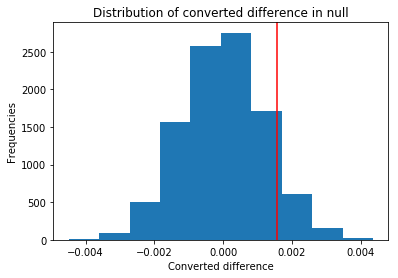

In [156]:
plt.hist(p_diffs);
plt.title('Distribution of converted difference in null')
plt.xlabel("Converted difference")
plt.ylabel("Frequencies")
plt.axvline(x=obs_diff, color='r')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [157]:
p_value = (p_diffs > obs_diff).mean()
print(p_value)

0.0932


p_diffs smaller than diff in df2

In [158]:
p2 = (p_diffs < obs_diff).mean()
print(p2)

0.9068


# The p-value is greater than Type I error = 0.05. Fail to reject the null hypothesis. 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [159]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = 17489

# number of conversions with the new_page
convert_new = 17264

# number of individuals who were shown the old_page
n_old = 145274

# number of individuals who received new_page
n_new = 145310

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

Ho: Rate for Old page > = Rate for New page , or
Rnew - Rold <= 0
H1: Rate for New page > Rate for Old page, or
Rnew - Rold > 0

In [160]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

Source: https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html
'In the two sample test, smaller means that the alternative hypothesis is p1 < p2 and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.'
p1=p_old
p2=P_new
H1: p_old < p_new

### It's a right-tailed if you defined 𝐻1 as (𝑝𝑛𝑒𝑤>𝑝𝑜𝑙𝑑).
### For a right-tailed test, reject null if  𝑍𝑠𝑐𝑜𝑟𝑒  >  𝑍𝛼 = 1,645
### 𝑍𝑠𝑐𝑜𝑟𝑒  = 1,31  <  𝑍𝛼

## Fail to reject null hypothesis: 
 ## Ho: Rate for Old page > = Rate for New page


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

## Logistic regression, y dependent variable and x explanatory variable

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [161]:
df2=df2.drop_duplicates(['user_id'], keep='first')

In [162]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [163]:
df2['intercept'] = 1

In [164]:
df2['ab_page'] = 0

In [165]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0


In [166]:
df2.loc[df2[df2['group']=='treatment'].index, "ab_page"] = 1

In [167]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [168]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [169]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Thu, 09 Jun 2022   Prob (F-statistic):              0.190
Time:                        19:20:26   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


### p-value associated with ab_page: 0.190, is greater than Type I error rate (0.05), fail to reject null.
### The null hypothesis:the difference between the new and old pages is = 0.
### The alternative: the difference is > 0 (new page rate is greter than old page rate).

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors to add into  regression model: age, graduated studies, occupy status, marital status

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [170]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [171]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [172]:
df_countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [173]:
# Join with the df2 dataframe
df2_countries = df2.set_index('user_id').join(df_countries.set_index('user_id'))

In [174]:
df2_countries.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [175]:
# Create the necessary dummy variables

In [176]:
df2_countries[['UK', 'US', 'CA' ]]= pd.get_dummies(df2_countries['country'])
df2_countries=df2_countries.drop('CA', axis=1)

In [177]:
df2_countries.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
user_id,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [178]:
#instantiate logistic regression model
df2_countries['intercept']= 1
lm =sm.OLS(df2_countries['converted'],df2_countries[['intercept', 'UK', 'US']])

In [179]:
# Fit your model, and summarize the results

In [180]:
results = lm.fit()

In [181]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Thu, 09 Jun 2022   Prob (F-statistic):              0.201
Time:                        19:20:27   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1195      0.001    166.244      0.000       0.118       0.121
UK            -0.0042      0.003     -1.516      0.130      -0.010       0.001
US             0.0010      0.001      0.746      0.455      -0.002       0.004
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [182]:
df2_countries['UK_ab_page'] = df2_countries['UK'] * df2_countries['ab_page']

In [183]:
df2_countries['US_ab_page'] = df2_countries['US'] * df2_countries['ab_page']

In [184]:
df2_countries.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


In [185]:
#instantiate logistic regression model
df2_countries['intercept']= 1
lm2 =sm.OLS(df2_countries['converted'], df2_countries[['intercept', 'UK', 'US', 'ab_page', 'UK_ab_page', 'US_ab_page']])

In [186]:
results2 = lm2.fit()

In [187]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Thu, 09 Jun 2022   Prob (F-statistic):              0.197
Time:                        19:20:27   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1206      0.001    118.563      0.000       0.119       0.123
UK            -0.0018      0.004     -0.467      0.641      -0.010       0.006
US            -0.0006      0.002     -0.307      0.759      -0.004       0.003
ab_page       -0.0022      0.001     -1.505      0.132      -0.005       0.001
UK_ab_page    -0.0047      0.006     -0.845      0.398      -0.016       0.006
US_ab_page     0.0033      0.003      1.180      0.238      -0.002       0.009
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The difference between p-values of Part 2 and 3 is because we have performed a one-tailed test in Part 2, and in Part 3, we are performing a two-tailed test. The two-tail P value is twice the one-tail P value (assuming you correctly predicted the direction of the difference).

### For significance p value must be smaller than 0.05. 
### Conclusion: the country is not significant in conversion rate and 
### interactions between variables are not significant ( p value for 
### UK_ab_page = 0.398 and for US_ab_page = 0.238),
### We can drop the country variable from our model and the interaction effects.

### Because we failed to reject the null hypothesis, we consider that there are no differences between the pages. We can still use the old page and in the future look for other criteria to improve the old page and create a new page.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [188]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0